In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [5]:
warnings.filterwarnings('ignore')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
df = pd.read_csv('experiment_data1.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   jobma_catcher_id                4461 non-null   int64  
 1   is_premium                      4461 non-null   int64  
 2   subscription_status             4461 non-null   int64  
 3   company_size                    4461 non-null   object 
 4   total_sub                       4461 non-null   int64  
 5   is_unlimited                    4461 non-null   int64  
 6   subscription_amount_in_dollars  4461 non-null   float64
 7   number_of_subscriptions         4461 non-null   int64  
 8   number_of_invitations           4461 non-null   int64  
 9   job_posted                      4461 non-null   int64  
 10  number_of_kits                  4461 non-null   int64  
 11  number_of_recorded_interviews   4461 non-null   int64  
 12  number_of_live_interviews       44

# Data Encoding

In [19]:
def ordinal_encoder(df):
    # Define the ordinal column and the ordering
    ordinal_col = ['company_size', 'days_since_last_login']
    company_size_order = ['1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    login_days_order = ['Less than 1 Week', '1-4 Weeks', '1-3 Months', '3-6 Months', '6-12 Months', 'More than 1 Year']

    total_order = [company_size_order, login_days_order]
    # Initialize OrdinalEncoder with specified categories
    ordinal = OrdinalEncoder(categories=total_order)
    
    # Fit and transform the data (make sure input is 2D for encoding)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))

    # Shift encoding to start from 1
    encoded += 1
    
    # Convert the encoded result to a DataFrame with the appropriate column name
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    # Drop the original column
    df.drop(columns=ordinal_col, inplace=True)

    # Concatenate the encoded column to the original dataframe
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [24]:
log_cols = [
    'total_sub',
    'subscription_amount_in_dollars',
    'number_of_subscriptions'
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'number_of_recorded_interviews',
    'number_of_live_interviews',
    'days_since_last_login'
]

In [27]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
            
    return df

# Pipeline

In [33]:
pipeline = Pipeline([
    # ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    # ('one_hot_encoder', CustomOneHotEncoder(columns=['is_premium', 'subscription_status', 'is_unlimited'])),
    # ('one_hot_encoder', FunctionTransformer(one_hot_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
])

In [36]:
set_config(display='diagram')
pipeline

Pipeline(steps=[('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x0000020FF02C1080>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x0000020FF3670040>)),
                ('scaler', StandardScaler())])

# Fit Pipeline

In [41]:
X = df

In [44]:
X_transformed = pipeline.fit_transform(X)

In [47]:
features_names = df.columns

In [50]:
X_df = pd.DataFrame(X_transformed)

In [54]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

# Dataset

In [58]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [61]:
X_data = CustomDataset(X_tensor)

# DataLoader

In [84]:
dataloader = DataLoader(X_data, batch_size=16, shuffle=False)

# AutoEncoder

In [90]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # bottleneck
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_shape)
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [93]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=14, bias=True)
  )
)

In [97]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 50
patience = 5
delta = 1e-4

best_loss = float('inf')
epochs_no_improve = 0
training_losses = []

In [100]:
''' Loss Function and Optimizers '''

# mse_loss_function = nn.MSELoss()
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training Loop

In [104]:
for epoch in range(epochs):
    model_1.train()
    epoch_loss = 0

    for batch in dataloader:
        encoded, decoded = model_1(batch)
        loss = loss_function(decoded, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    training_losses.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss - delta:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']:.6f}")

Epoch 1/50 | Loss: 0.174210
Learning Rate: 0.001000
Epoch 2/50 | Loss: 0.124472
Learning Rate: 0.001000
Epoch 3/50 | Loss: 0.098782
Learning Rate: 0.001000
Epoch 4/50 | Loss: 0.090321
Learning Rate: 0.001000
Epoch 5/50 | Loss: 0.084661
Learning Rate: 0.001000
Epoch 6/50 | Loss: 0.078480
Learning Rate: 0.001000
Epoch 7/50 | Loss: 0.067981
Learning Rate: 0.001000
Epoch 8/50 | Loss: 0.061734
Learning Rate: 0.001000
Epoch 9/50 | Loss: 0.056939
Learning Rate: 0.001000
Epoch 10/50 | Loss: 0.054846
Learning Rate: 0.001000
Epoch 11/50 | Loss: 0.054754
Learning Rate: 0.001000
Epoch 12/50 | Loss: 0.051252
Learning Rate: 0.001000
Epoch 13/50 | Loss: 0.053459
Learning Rate: 0.001000
Epoch 14/50 | Loss: 0.049739
Learning Rate: 0.001000
Epoch 15/50 | Loss: 0.048348
Learning Rate: 0.001000
Epoch 16/50 | Loss: 0.048370
Learning Rate: 0.001000
Epoch 17/50 | Loss: 0.047409
Learning Rate: 0.001000
Epoch 18/50 | Loss: 0.046882
Learning Rate: 0.001000
Epoch 19/50 | Loss: 0.044858
Learning Rate: 0.001000
Ep

# Clustering

In [108]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [110]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [112]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

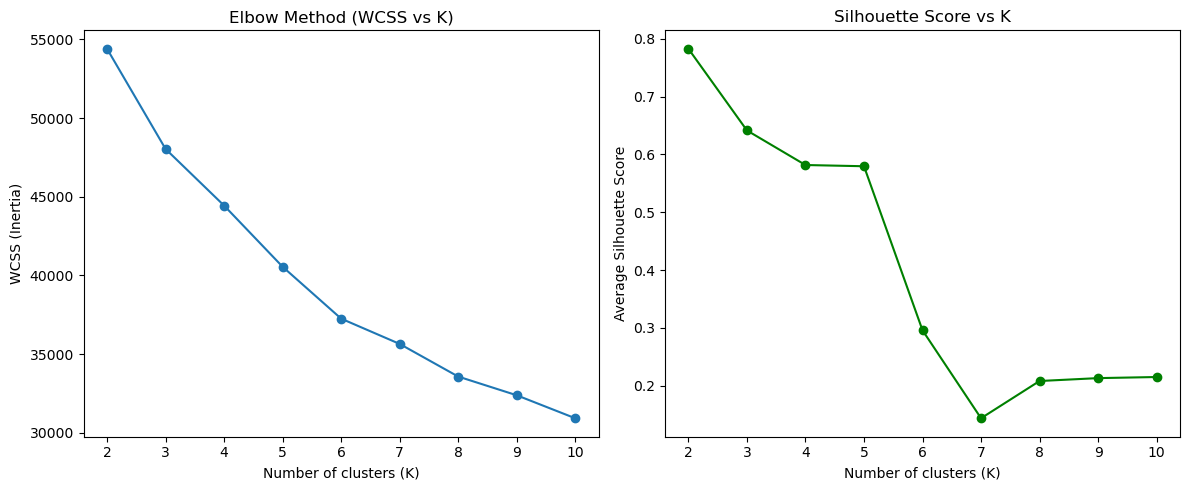

In [114]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [116]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

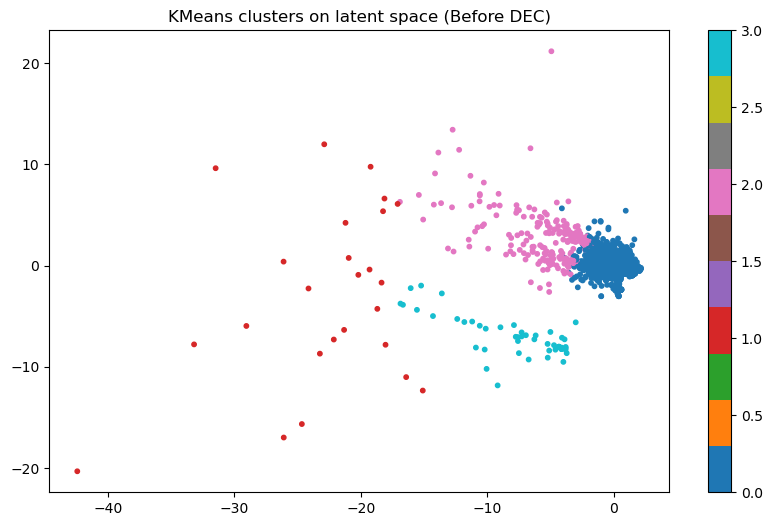

In [118]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

# DEC

In [122]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [124]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [126]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=5e-4)
batch_size = dataloader.batch_size

In [129]:
dec.train()
num_epochs = 50
for epoch in range(num_epochs):
    # Compute global soft assignments q_all
    with torch.no_grad():
        q_all, _ = dec(X_tensor.to(device))            
        p_all = target_distribution(q_all)              

    epoch_loss = 0.0
    for batch_idx, batch in enumerate(dataloader):
        x = batch.to(device)
        q_batch, _ = dec(x)                            

        # Slice the matching rows from p_all
        start = batch_idx * batch_size
        end   = start + x.size(0)
        p_batch = p_all[start:end].to(device)          

        # Compute loss against the global target
        loss = kl_loss(torch.log(q_batch + 1e-8), p_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(X_tensor)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg KL Loss: {avg_loss:.4f}")

Epoch 1/50, Avg KL Loss: 0.0352
Epoch 2/50, Avg KL Loss: 0.0546
Epoch 3/50, Avg KL Loss: 0.0693
Epoch 4/50, Avg KL Loss: 0.0820
Epoch 5/50, Avg KL Loss: 0.0944
Epoch 6/50, Avg KL Loss: 0.1014
Epoch 7/50, Avg KL Loss: 0.1044
Epoch 8/50, Avg KL Loss: 0.1084
Epoch 9/50, Avg KL Loss: 0.1077
Epoch 10/50, Avg KL Loss: 0.1080
Epoch 11/50, Avg KL Loss: 0.1076
Epoch 12/50, Avg KL Loss: 0.1060
Epoch 13/50, Avg KL Loss: 0.1076
Epoch 14/50, Avg KL Loss: 0.1119
Epoch 15/50, Avg KL Loss: 0.1067
Epoch 16/50, Avg KL Loss: 0.1111
Epoch 17/50, Avg KL Loss: 0.1093
Epoch 18/50, Avg KL Loss: 0.1019
Epoch 19/50, Avg KL Loss: 0.0978
Epoch 20/50, Avg KL Loss: 0.0980
Epoch 21/50, Avg KL Loss: 0.0956
Epoch 22/50, Avg KL Loss: 0.0979
Epoch 23/50, Avg KL Loss: 0.0966
Epoch 24/50, Avg KL Loss: 0.1024
Epoch 25/50, Avg KL Loss: 0.0968
Epoch 26/50, Avg KL Loss: 0.1002
Epoch 27/50, Avg KL Loss: 0.0963
Epoch 28/50, Avg KL Loss: 0.0940
Epoch 29/50, Avg KL Loss: 0.0964
Epoch 30/50, Avg KL Loss: 0.0973
Epoch 31/50, Avg KL

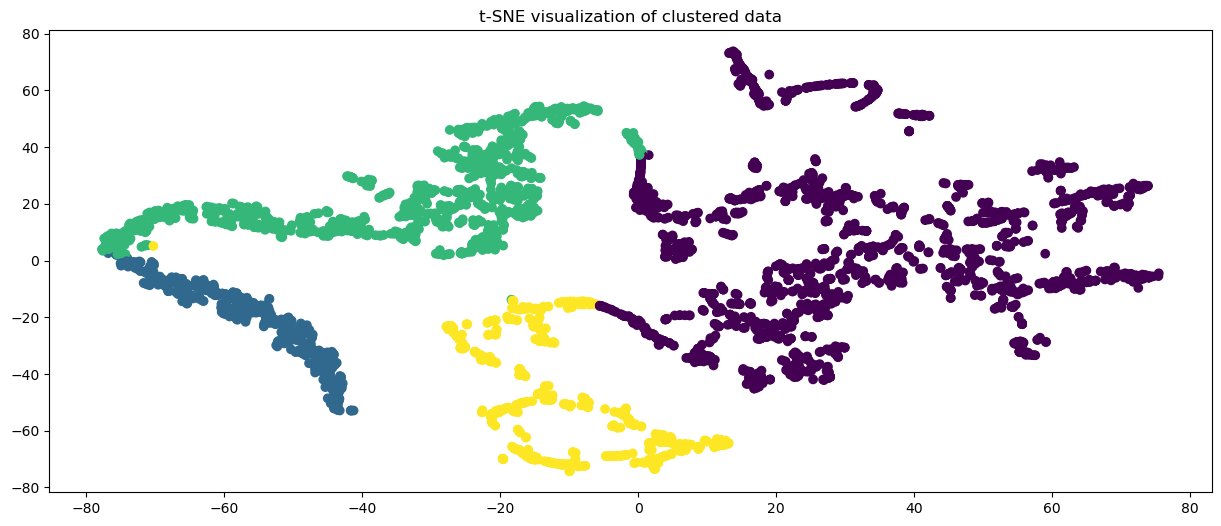

In [152]:
''' Visualizing the Clusters '''

dec.eval()

with torch.no_grad():
    q, _ = dec(X_tensor.to(device))  # Get cluster assignments
    preds = torch.argmax(q, dim=1).cpu().numpy()

with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [140]:
''' Add cluster labels to original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [142]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
cluster_summary

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews
cluster_id,,,,,,,,,,,,
0,6632.992757,0.160706,0.773653,0.092802,0.112721,1622.463178,1.512449,0.079221,0.020371,0.045269,0.005885,0.000000
1,7243.093617,0.378723,0.572340,1.861702,0.229787,261050.693003,5.321277,167.487234,8.174468,9.436170,28.025532,0.761702
2,6236.734278,0.313552,0.716563,0.494243,0.392383,125046.189192,2.503986,2.688220,0.566873,0.573959,0.331267,0.009743
3,5562.549770,0.140888,0.871363,0.009188,0.189893,98.014114,1.171516,0.134763,0.062787,0.079632,0.044410,0.000000


In [144]:
unique_clusters = np.unique(preds)
print(f"Unique Clusters Found: {len(unique_clusters)} -> {unique_clusters}")

Unique Clusters Found: 4 -> [0 1 2 3]


# Final Step: Add Meaningful Cluster Labels for Recommendation System

In [160]:
cluster_names = {
    0: "Passive",   # Average
    1: "Loyal",   # Active
    2: "Engaged",   # Very Low Activity
    3: "Dormant"
}
df_train['cluster_label'] = df_train['cluster_id'].map(cluster_names)

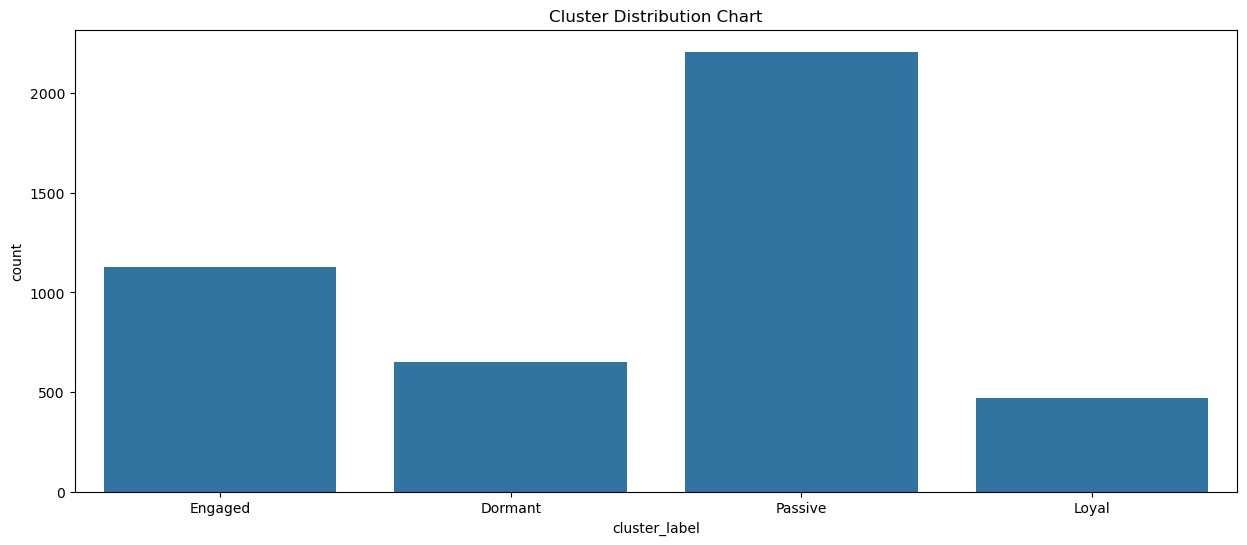

In [162]:
''' Visualizing the Cluster as a chart to determine the distribution of labels '''

plt.figure(figsize=(15,6))
sns.countplot(x='cluster_label', data=df_train)
plt.title('Cluster Distribution Chart')
plt.show()

# Recommendation System

In [164]:
original_df = pd.read_csv('experiment_data.csv')

In [176]:
# def recommend(df, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal'):
#     loyal_df = df[df['cluster_label'] == label]
#     top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)
#     merged_df = pd.merge(top_clients_df,
#                          original_df[['jobma_catcher_id', 'company_size', 'is_premium']], 
#                          on='jobma_catcher_id', 
#                          how='left', 
#                          suffixes=('_train', '_orig'))

#     # columns_to_return = [col for col in ['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium'] if col in merged_df.columns]
    
#     return merged_df[[
#         'jobma_catcher_id',
#         'company_size_orig',
#         'is_premium_orig'
#     ]].rename(columns={
#         'company_size_orig': 'company_size',
#         'is_premium_orig'  : 'is_premium'
#     })

In [200]:
original_df.columns

Index(['jobma_catcher_id', 'is_premium', 'subscription_status', 'company_size',
       'total_sub', 'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews', 'days_since_last_login'],
      dtype='object')

In [212]:
def recommend(df, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal'):     
    loyal_df = df[df['cluster_label'] == label]     
    top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)     
    return top_clients_df

In [210]:
''' Loyal '''

result_loyal = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal')
result_loyal

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
2610,6964,0,0,1,1,1.188726e+08,19,0,0,0,0,0,1,Loyal
2561,6909,1,0,1,0,3.624921e+05,10,4,1,1,1,0,1,Loyal
3309,7831,0,1,1,1,2.700500e+05,25,0,0,0,0,0,1,Loyal
507,3678,1,1,13,0,2.078895e+05,33,485,92,27,215,18,1,Loyal
3004,7465,0,1,1,1,1.712500e+05,16,0,0,0,0,0,1,Loyal


In [216]:
''' Dormant '''

result_dormant = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Dormant')
result_dormant

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
4417,10474,0,0,0,1,20000.0,2,0,0,3,0,0,3,Dormant
4401,10440,0,1,0,0,10100.0,2,0,0,0,0,0,3,Dormant
4123,10000,0,0,1,1,10000.0,1,4,1,3,2,0,3,Dormant
4440,10511,0,0,0,1,10000.0,1,0,0,0,0,0,3,Dormant
4436,10507,0,0,0,1,10000.0,1,0,0,0,0,0,3,Dormant
